In [1]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import RobertaConfig, RobertaModel, AutoTokenizer, AutoModel, RobertaTokenizerFast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Choose Model

In [2]:
config = 'ChemGPT'
model_type = 'GPT' #GPT or roberta
mode = 'val' #val or test

In [3]:
if config == 'random_init':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    configuration = RobertaConfig()
    base_model = RobertaModel(configuration)
    
elif config == 'roberta':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    configuration = RobertaConfig()
    base_model = RobertaModel(configuration)
    configuration = base_model.config

elif config == 'ChemBERTa_pubchem':
    tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTA_PubChem1M_shard00_155k")
    base_model = AutoModel.from_pretrained("seyonec/ChemBERTA_PubChem1M_shard00_155k")
    
elif config == 'ChemBERTa_10M':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    base_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-10M-MTR")

elif config == 'ChemGPT':
    tokenizer = AutoTokenizer.from_pretrained("ncfrey/ChemGPT-1.2B")
    base_model = AutoModel.from_pretrained("ncfrey/ChemGPT-1.2B")

In [4]:
num_params = 0
for params in base_model.parameters():
    num_params+=params.numel()
print('Total number of parameters in selected model (without head):',num_params)

Total number of parameters in selected model (without head): 1214050304


In [5]:
class FullModel(nn.Module):
    def __init__(self, base_model, model_type, num_outputs):
        super(FullModel, self).__init__()
        self.model_type = model_type
        self.base = base_model
        
        self.lin1 = nn.Linear(base_model.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(512, num_outputs)

    def forward(self, input_ids, attention_mask):
        # Pass the input through base model
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)

        # Apply the linear layer for classification
        if model_type == 'roberta':
            x = self.relu(self.lin1(outputs['pooler_output']))
        elif model_type =='GPT':
            x = self.relu(self.lin1(outputs['last_hidden_state'][:,-1,:]))
        x = self.lin2(x)

        return x

In [6]:
for param in base_model.parameters():
    param.requires_grad = False
    
model = FullModel(base_model, model_type, num_outputs = 4)

torch.cuda.set_device(2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FullModel(
  (base): GPTNeoModel(
    (wte): Embedding(684, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_featur

## Loading Data and Preprocessing

In [7]:
df = pd.read_csv('parkinsons.csv')
selected_columns = ['Molecular Weight', '#RO5 Violations','Smiles', 'AlogP', 'pChEMBL Value']
columns_to_check = ['Molecular Weight', '#RO5 Violations', 'AlogP', 'pChEMBL Value']
for col in columns_to_check:
    df = df[pd.to_numeric(df[col], errors='coerce').notnull()]
df_selected = df[selected_columns].dropna()
# df_selected

In [8]:
test_size = 0.2
val_size = 0.5

train_df, test_df = train_test_split(df_selected, test_size=test_size, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=val_size, random_state=42)

In [9]:
class smiles_dataset(Dataset):
 
    def __init__(self,df):
        if tokenizer.pad_token is None:
            print("no padding defined in tokenizer, using [PAD] token by default")
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.encodings = tokenizer(df["Smiles"].tolist(), return_tensors="pt",truncation=True, padding=True)
        data = df[['Molecular Weight', '#RO5 Violations', 'AlogP','pChEMBL Value']].values.astype(float)
        
        self.y = torch.tensor(data, dtype=torch.float32)
        mean = self.y.mean(dim=0)
        std = self.y.std(dim=0)
        self.y = (self.y - mean) / std
    
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        input_ids = self.encodings['input_ids'][idx]
        attention_mask = self.encodings['attention_mask'][idx]
        return (input_ids, attention_mask),self.y[idx]

In [10]:
train_data = smiles_dataset(train_df)
test_data = smiles_dataset(test_df)
val_data = smiles_dataset(val_df)

batch_size = 32

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
if mode=='val':
    eval_dataloader = DataLoader(val_data, batch_size = batch_size)
elif mode=='test':
    eval_dataloader = DataLoader(test_data, batch_size = batch_size)

Using pad_token, but it is not set yet.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


no padding defined in tokenizer, using [PAD] token by default


## Train

In [11]:
learning_rate = 1e-8
num_epochs = 25
weight_decay=0
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [12]:
train_f1_list = []
test_f1_list = []
loss_train = []
loss_test=[]

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for n, ((input_ids,attention_mask),targets) in enumerate(tqdm(train_dataloader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)
        
        outputs = model(input_ids = input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}")
    loss_train.append(train_loss)
    
    model.eval()
    total_loss = 0
    for n, ((input_id,attention_mask),labels) in enumerate(eval_dataloader):
        input_id = input_id.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_id, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    
    eval_loss = total_loss / len(eval_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Eval Loss: {eval_loss}")
    loss_test.append(eval_loss)

100%|█████████████████████████████████████████| 295/295 [01:33<00:00,  3.17it/s]


Epoch 1/25, Train Loss: 1.0464139954518463
Epoch 1/25, Eval Loss: 1.040549692269918


100%|█████████████████████████████████████████| 295/295 [02:31<00:00,  1.95it/s]


Epoch 2/25, Train Loss: 1.038395233073477
Epoch 2/25, Eval Loss: 1.036981995041306


100%|█████████████████████████████████████████| 295/295 [02:51<00:00,  1.72it/s]


Epoch 3/25, Train Loss: 1.0351020584672184
Epoch 3/25, Eval Loss: 1.0338165969462008


100%|█████████████████████████████████████████| 295/295 [02:51<00:00,  1.72it/s]


Epoch 4/25, Train Loss: 1.0247690217979883
Epoch 4/25, Eval Loss: 1.0310247314942849


100%|█████████████████████████████████████████| 295/295 [02:51<00:00,  1.72it/s]


Epoch 5/25, Train Loss: 1.019500338223021
Epoch 5/25, Eval Loss: 1.0285263947538428


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 6/25, Train Loss: 1.017574679851532
Epoch 6/25, Eval Loss: 1.02638785581331


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 7/25, Train Loss: 1.0107892028356003
Epoch 7/25, Eval Loss: 1.0245690506857794


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 8/25, Train Loss: 1.0074041305962256
Epoch 8/25, Eval Loss: 1.0230206041722685


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 9/25, Train Loss: 1.0028575608285808
Epoch 9/25, Eval Loss: 1.0216865281800966


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 10/25, Train Loss: 1.0005422877053083
Epoch 10/25, Eval Loss: 1.0205647462123149


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 11/25, Train Loss: 0.9979679711794449
Epoch 11/25, Eval Loss: 1.0196451721964657


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 12/25, Train Loss: 0.9951534713728953
Epoch 12/25, Eval Loss: 1.018894910812378


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 13/25, Train Loss: 0.9943734548859677
Epoch 13/25, Eval Loss: 1.0183188576956053


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 14/25, Train Loss: 0.9927012958769071
Epoch 14/25, Eval Loss: 1.0178990315746617


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 15/25, Train Loss: 0.9903535506482851
Epoch 15/25, Eval Loss: 1.017631923830187


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 16/25, Train Loss: 0.9897423528008542
Epoch 16/25, Eval Loss: 1.0174844748265035


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 17/25, Train Loss: 0.989862270072355
Epoch 17/25, Eval Loss: 1.0174449118407998


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 18/25, Train Loss: 0.9895237984293598
Epoch 18/25, Eval Loss: 1.0175107556420404


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 19/25, Train Loss: 0.9874799685963129
Epoch 19/25, Eval Loss: 1.0176732169615257


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 20/25, Train Loss: 0.987523182569924
Epoch 20/25, Eval Loss: 1.017928571314425


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 21/25, Train Loss: 0.9880454506914494
Epoch 21/25, Eval Loss: 1.0182590871243864


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 22/25, Train Loss: 0.9877727274167336
Epoch 22/25, Eval Loss: 1.0186659516514958


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 23/25, Train Loss: 0.98988424559771
Epoch 23/25, Eval Loss: 1.0191406720393412


100%|█████████████████████████████████████████| 295/295 [02:46<00:00,  1.78it/s]


Epoch 24/25, Train Loss: 0.990107697753583
Epoch 24/25, Eval Loss: 1.0196734070777893


100%|█████████████████████████████████████████| 295/295 [02:50<00:00,  1.73it/s]


Epoch 25/25, Train Loss: 0.9887354527489614
Epoch 25/25, Eval Loss: 1.0202648398038503


## Plot results

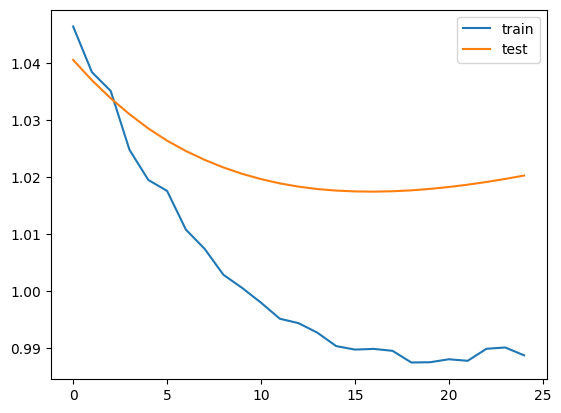

In [13]:
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.legend()

In [14]:
num_variables = 4

model.eval()  # Set the model to evaluation mode
total_mae_per_variable = [0.0] * num_variables
total_samples = 0

with torch.no_grad():
    for (input_ids, attention_mask), targets in eval_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)
        predictions = model(input_ids = input_ids, attention_mask=attention_mask)

        for i in range(num_variables):
            mae_per_batch = F.l1_loss(predictions[:, i], targets[:, i], reduction='sum').item()
            total_mae_per_variable[i] += mae_per_batch

        total_samples += len(targets)

mean_absolute_error_per_variable = [mae / total_samples for mae in total_mae_per_variable]
mean_absolute_error_per_variable

[0.7016629411733009,
 0.7313165235600366,
 0.7140055180405518,
 0.8308375104376334]

In [15]:
y = df_selected[['Molecular Weight', '#RO5 Violations', 'AlogP','pChEMBL Value']].values.astype(float)
y = torch.tensor(y, dtype=torch.float32)
mean = y.mean(dim=0)
std = y.std(dim=0)
MAE = torch.tensor(mean_absolute_error_per_variable)*std
MAE

tensor([71.4222,  0.4316,  0.9189,  0.9366])